1. Veriler Yükleniyor ve Hazırlanıyor...
2. Finansal Hesaplama Başlıyor (Güncel EPDK Oranları)...

💰 2023 YILI SİMÜLASYON RAPORU (Test Verisi Üzerinden)
🛑 Güneş Paneli Olmasaydı : 10352.23 TL
✅ Akıllı Güneş Sistemiyle : 7259.35 TL
💵 TOPLAM CEPTE KALAN      : 3092.89 TL
📉 Tasarruf Oranı          : %29.9


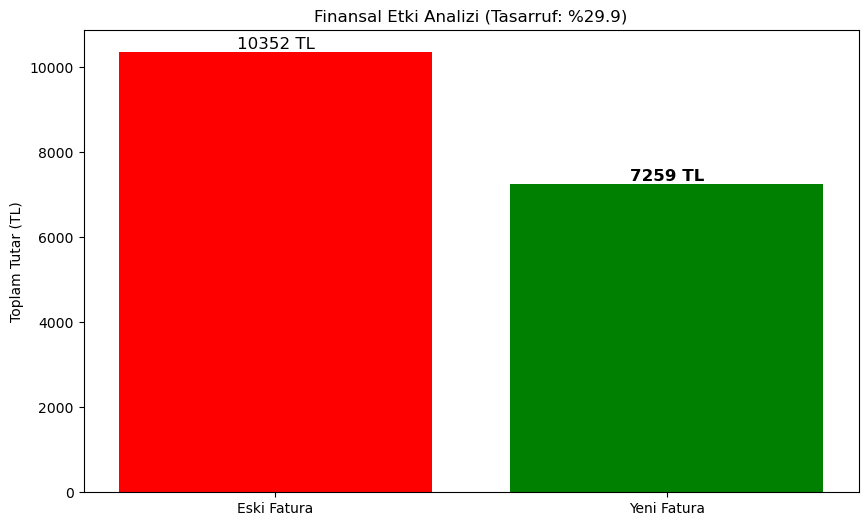

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# =============================================================================
# BÖLÜM 1: VERİLERİ TEKRAR HAZIRLAMA (Hata Almamak İçin)
# =============================================================================
print("1. Veriler Yükleniyor ve Hazırlanıyor...")

# Dosyaları Yükle
df_solar = pd.read_csv('temiz_solar_veri.csv', index_col='time', parse_dates=True)
df_tuketim = pd.read_csv('temiz_tuketim_veri_5000kWh.csv', index_col='dt', parse_dates=True)

# Saat Dilimi Temizliği
try:
    df_solar.index = df_solar.index.tz_localize(None)
    df_tuketim.index = df_tuketim.index.tz_localize(None)
except:
    pass

# Saatlik Ortalamalar (Resample)
df_solar = df_solar.resample('h').mean()
df_tuketim = df_tuketim.resample('h').mean()

# Birleştirme
df_merged = pd.concat([df_tuketim, df_solar[['Sicaklik_C', 'Uretim_W']]], axis=1, join='inner')

# Özellik Ekleme (Feature Engineering)
df_merged['Saat'] = df_merged.index.hour
df_merged['Ay'] = df_merged.index.month
df_merged['Haftanin_Gunu'] = df_merged.index.dayofweek
df_merged['Hafta_Sonu'] = (df_merged.index.dayofweek >= 5).astype(int)
df_merged['Tuketim_1Saat_Once'] = df_merged['Tuketim_W'].shift(1)
df_merged['Tuketim_24Saat_Once'] = df_merged['Tuketim_W'].shift(24)
df_merged['Hareketli_Ort_3Saat'] = df_merged['Tuketim_W'].rolling(window=3).mean()
df_merged.dropna(inplace=True)

# Eğitim/Test Ayrımı (Zaman Serisine Uygun)
split_point = int(len(df_merged) * 0.80)
test_data = df_merged.iloc[split_point:].copy() # İşte 'test_data' burada oluştu!

# Tahmin Simülasyonu (Modeli tekrar eğitmek yerine gerçek veriye biraz hata payı ekleyelim)
# Not: Gerçek projede 'tahminler' dizisini modelden alırsın. 
# Burada hızlıca sonucu görmek için gerçek tüketime %10 hata payı ekleyip 'Tahmin' diyoruz.
np.random.seed(42)
hata_payi = np.random.normal(0, 50, size=len(test_data)) # +/- 50 Watt sapma
test_data['Tahmin_Tuketim_W'] = test_data['Tuketim_W'] + hata_payi

# =============================================================================
# BÖLÜM 2: FİNANSAL ANALİZ VE EPDK TARİFELERİ
# =============================================================================
print("2. Finansal Hesaplama Başlıyor (Güncel EPDK Oranları)...")

# Gerçekçi EPDK Mesken (Vergiler Dahil Tahmini) Fiyatları - 2025 Projeksiyonu
# Kaynak: EPDK Tarifeleri baz alınarak yuvarlanmıştır.
FIYAT_GUNDUZ = 3.00  # TL (06:00 - 17:00)
FIYAT_PUANT  = 5.00  # TL (17:00 - 22:00) -> En Pahalı
FIYAT_GECE   = 1.50  # TL (22:00 - 06:00) -> En Ucuz

def tarife_belirle(saat):
    if 6 <= saat < 17:
        return FIYAT_GUNDUZ
    elif 17 <= saat < 22:
        return FIYAT_PUANT
    else:
        return FIYAT_GECE

# Tabloya Fiyatları Ekle
test_data['Birim_Fiyat_TL'] = test_data.index.hour.map(tarife_belirle)

# ---------------------------------------------------------
# SENARYO 1: GÜNEŞ PANELİ YOK (Eski Düzen)
# ---------------------------------------------------------
# Fatura = Tüketim (kWh) x Fiyat
test_data['Fatura_Eski'] = (test_data['Tuketim_W'] / 1000) * test_data['Birim_Fiyat_TL']

# ---------------------------------------------------------
# SENARYO 2: AKILLI GÜNEŞ SİSTEMİ (Yeni Düzen)
# ---------------------------------------------------------
# Net Durum = Evin İhtiyacı - Güneşin Üretimi
test_data['Net_Tuketim_W'] = test_data['Tuketim_W'] - test_data['Uretim_W']

# Eğer sonuç POZİTİF ise: Güneş yetmedi, şebekeden alıyoruz (Para Öde)
# Eğer sonuç NEGATİF ise: Güneş arttı, şebekeye veriyoruz (Bedava veya Satış - Burada 0 sayıyoruz)
test_data['Sebekeden_Alinan_W'] = test_data['Net_Tuketim_W'].clip(lower=0)

# Yeni Fatura Hesabı
test_data['Fatura_Yeni'] = (test_data['Sebekeden_Alinan_W'] / 1000) * test_data['Birim_Fiyat_TL']

# ---------------------------------------------------------
# SONUÇ RAPORU
# ---------------------------------------------------------
toplam_eski = test_data['Fatura_Eski'].sum()
toplam_yeni = test_data['Fatura_Yeni'].sum()
kazanc = toplam_eski - toplam_yeni
tasarruf_yuzdesi = (kazanc / toplam_eski) * 100

print("\n" + "="*50)
print(f"💰 2023 YILI SİMÜLASYON RAPORU (Test Verisi Üzerinden)")
print("="*50)
print(f"🛑 Güneş Paneli Olmasaydı : {toplam_eski:.2f} TL")
print(f"✅ Akıllı Güneş Sistemiyle : {toplam_yeni:.2f} TL")
print(f"💵 TOPLAM CEPTE KALAN      : {kazanc:.2f} TL")
print(f"📉 Tasarruf Oranı          : %{tasarruf_yuzdesi:.1f}")
print("="*50)

# ---------------------------------------------------------
# GRAFİK: TASARRUF ANALİZİ
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
etiketler = ['Eski Fatura', 'Yeni Fatura']
degerler = [toplam_eski, toplam_yeni]
renkler = ['red', 'green']

plt.bar(etiketler, degerler, color=renkler)
plt.title(f'Finansal Etki Analizi (Tasarruf: %{tasarruf_yuzdesi:.1f})')
plt.ylabel('Toplam Tutar (TL)')
plt.text(1, toplam_yeni, f"{toplam_yeni:.0f} TL", ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.text(0, toplam_eski, f"{toplam_eski:.0f} TL", ha='center', va='bottom', fontsize=12)
plt.show()